# Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Load Data

In [2]:
train = pd.read_csv('application_train.csv')
biro = pd.read_csv('bureau.csv')
credit = pd.read_csv('credit_card_balance.csv')
prev = pd.read_csv('previous_application.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## Merge Dataframe

Dikarenakan data credit dan prev memiliki baris yang sangat banyak, sehingga kami mengalami keterbatasan dalam processing maka kami memperkecil ukuran data hampir sama dengan data train (untuk barisnya)

In [4]:
credit = credit.sample(n=307600,random_state = 123)
prev = prev.sample (n= 307600, random_state=123)

In [5]:
# Menggabungkan kolom dari data biro
train = pd.merge(train, biro[['SK_ID_CURR', 'DAYS_CREDIT','CREDIT_CURRENCY']], on='SK_ID_CURR', how='left')

# Menggabungkan kolom dari data credit
train = pd.merge(train, credit[['SK_ID_CURR', 'AMT_RECIVABLE']], on='SK_ID_CURR', how='left')

# Menggabungkan kolom dari data previous
train = pd.merge(train, prev[['SK_ID_CURR', 'FLAG_LAST_APPL_PER_CONTRACT']], on='SK_ID_CURR', how='left')


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4049524 entries, 0 to 4049523
Columns: 126 entries, SK_ID_CURR to FLAG_LAST_APPL_PER_CONTRACT
dtypes: float64(67), int64(41), object(18)
memory usage: 3.8+ GB


In [7]:
train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_CURRENCY,AMT_RECIVABLE,FLAG_LAST_APPL_PER_CONTRACT
2457783,315634,0,Cash loans,M,Y,Y,1,157500.0,604152.0,39780.0,...,0.0,0.0,0.0,0.0,0.0,3.0,-851.0,currency 1,NaN,NaN
610883,154140,0,Cash loans,F,N,N,1,81000.0,254700.0,17149.5,...,0.0,0.0,0.0,0.0,1.0,3.0,-1324.0,currency 1,NaN,Y
1892820,266450,0,Cash loans,M,Y,N,0,225000.0,675000.0,29731.5,...,0.0,0.0,0.0,0.0,0.0,3.0,-1813.0,currency 1,88788.555,NaN
112237,110246,0,Cash loans,F,N,N,0,90000.0,810000.0,23683.5,...,0.0,0.0,0.0,1.0,0.0,6.0,-2827.0,currency 1,0.000,Y
1830762,261310,0,Cash loans,F,Y,Y,1,157500.0,528633.0,22527.0,...,0.0,0.0,0.0,3.0,2.0,5.0,-126.0,currency 1,0.000,Y


Dikarenakan kolom(fitur) terlalu banyak  >100, untuk mempermudah preprocessing maka kami membagi kolom-kolom tersebut menjadi beberapa kelompok 

In [8]:
# Mengelompokkan kolom berdasarkan kategori informasi
loan = ['SK_ID_CURR', 'TARGET', 'AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE']
borrower= ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
                 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL','FLAG_EMP_PHONE',
                 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL', 
                 'CNT_FAM_MEMBERS','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'TARGET']
loan_app = ['HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                 'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                 'LIVE_CITY_NOT_WORK_CITY','TARGET']
biro_kredit = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']
properti_avg = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
                 'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG',
                 'LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG']
properti_medi = ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI',
                 'COMMONAREA_MEDI', 'ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI',
                 'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']
properti_mode = ['APARTMENTS_MODE', 'BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE',
                 'COMMONAREA_MODE', 'ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE',
                 'LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE',
                       'TOTALAREA_MODE']
behavior = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                 'DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                  'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
                 'AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']
bukti = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6',
              'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11', 
              'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
              'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21', 'TARGET']
other = ['DAYS_CREDIT', 'AMT_RECIVABLE']
cats = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE','TARGET','FLAG_LAST_APPL_PER_CONTRACT','CREDIT_CURRENCY']


# DATA PREPROCESSING

## Missing Values

In [9]:
train[loan].isna().sum()/ train.shape[0] * 100

SK_ID_CURR         0.000000
TARGET             0.000000
AMT_CREDIT         0.000000
AMT_ANNUITY        0.005704
AMT_GOODS_PRICE    0.045758
dtype: float64


Missing value pada kolom goods_price dan annuity di bawah 1% maka kami mempertimbangkan untuk membuang baris tersebut


In [10]:
train.dropna(subset=['AMT_GOODS_PRICE'], inplace=True)
train.dropna(subset=['AMT_ANNUITY'], inplace=True)

In [11]:
train[borrower].isna().sum()

CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
REGION_POPULATION_RELATIVE     0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
TARGET                         0
dtype: int64

In [12]:
train[biro_kredit].isna().sum() / train.shape[0] * 100

EXT_SOURCE_1    52.787194
EXT_SOURCE_2     0.075233
EXT_SOURCE_3     4.559845
TARGET           0.000000
dtype: float64

Dikarenakan ketiga kolom diatas cenderung berdistribusi normal dan tidak terdapat outlier maka kami mempertimbangkan untuk
mengisi null values dengan mean/nilai rata-rata untuk kolom dengan proporsi null values 56% dan sisanya kami akan drop null values

In [13]:
train['EXT_SOURCE_1'].fillna(train['EXT_SOURCE_1'].mean(), inplace=True)
train.dropna(subset=['EXT_SOURCE_2'], inplace=True)
train.dropna(subset=['EXT_SOURCE_3'], inplace=True)

In [14]:
train[properti_mode].isna().sum() / train.shape[0] * 100

APARTMENTS_MODE                 46.569146
BASEMENTAREA_MODE               54.573363
YEARS_BEGINEXPLUATATION_MODE    44.528510
YEARS_BUILD_MODE                63.140662
COMMONAREA_MODE                 66.807180
ELEVATORS_MODE                  49.028550
ENTRANCES_MODE                  46.055334
FLOORSMAX_MODE                  45.549553
FLOORSMIN_MODE                  64.692898
LANDAREA_MODE                   55.516745
LIVINGAPARTMENTS_MODE           65.201607
LIVINGAREA_MODE                 45.872010
NONLIVINGAPARTMENTS_MODE        66.405897
NONLIVINGAREA_MODE              50.814185
TOTALAREA_MODE                  44.051923
dtype: float64

Kolom pada kelompok ini semuanya memiliki missing values yang sangat besar, dan hampir setengah dari data yang ada,dikarenakan semuanya terdapat outlier dan cenderung memiliki skewness, maka kami mengisi null values dengan nilai median

In [15]:
col = ['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                           'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                           'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
                           'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE']

for column in col:
    median_value = train[column].median()
    train[column].fillna(median_value, inplace=True)

In [16]:
train[behavior].isna().sum() / train.shape[0] * 100

OBS_30_CNT_SOCIAL_CIRCLE      0.14237
DEF_30_CNT_SOCIAL_CIRCLE      0.14237
DEF_60_CNT_SOCIAL_CIRCLE      0.14237
DAYS_LAST_PHONE_CHANGE        0.00000
AMT_REQ_CREDIT_BUREAU_HOUR    0.00000
AMT_REQ_CREDIT_BUREAU_DAY     0.00000
AMT_REQ_CREDIT_BUREAU_WEEK    0.00000
AMT_REQ_CREDIT_BUREAU_MON     0.00000
AMT_REQ_CREDIT_BUREAU_QRT     0.00000
AMT_REQ_CREDIT_BUREAU_YEAR    0.00000
TARGET                        0.00000
dtype: float64

Terdapat missing value pada semua kolom kategori ini yang kebanyakan diantaranya dengan persentase 0.02 untuk kolom `OBS_30_CNT_SOCIAL_CIRCLE`, `DEF_30_CNT_SOCIAL_CIRCLE`,`DEF_60_CNT_SOCIAL_CIRCLE`,  sehingga untuk missing value dibawah 1% kami mempertimbangkan untuk drop values.

In [17]:

drop_columns = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                'DEF_60_CNT_SOCIAL_CIRCLE']

train.dropna(subset=drop_columns, inplace=True)



In [18]:
train[cats].isna().sum() / train.shape[0] * 100

NAME_CONTRACT_TYPE              0.000000
CODE_GENDER                     0.000000
FLAG_OWN_CAR                    0.000000
FLAG_OWN_REALTY                 0.000000
NAME_TYPE_SUITE                 0.217413
NAME_INCOME_TYPE                0.000000
NAME_EDUCATION_TYPE             0.000000
NAME_FAMILY_STATUS              0.000000
NAME_HOUSING_TYPE               0.000000
OCCUPATION_TYPE                30.670796
WEEKDAY_APPR_PROCESS_START      0.000000
ORGANIZATION_TYPE               0.000000
FONDKAPREMONT_MODE             65.227690
HOUSETYPE_MODE                 45.994870
WALLSMATERIAL_MODE             46.520699
EMERGENCYSTATE_MODE            43.210833
TARGET                          0.000000
FLAG_LAST_APPL_PER_CONTRACT    26.241514
CREDIT_CURRENCY                 0.070145
dtype: float64

Terdapat beberapa missing values dengan proporsi 2-30% pada beberapa kolom, dan missing value dengan proporsi 45%-65% pada beberapa kolom lainnya, maka kami mempertimbangan untuk drop values pada proporsi yang sedikit dan mengisi null values dproporsi banyak dengan mode value karena kolom bertipe kategori 

In [19]:
train.dropna(subset=['NAME_TYPE_SUITE','FLAG_LAST_APPL_PER_CONTRACT', 'OCCUPATION_TYPE', 'CREDIT_CURRENCY'], inplace=True)

fill_mode = ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 
             'EMERGENCYSTATE_MODE']

for col in fill_mode:
    mode_value = train[col].mode().iloc[0]
    train[col].fillna(mode_value, inplace=True)


In [20]:
train[other].isna().sum() / train.shape[0] * 100

DAYS_CREDIT       0.000000
AMT_RECIVABLE    30.974504
dtype: float64

Dikarenakan AMT_RECIVABLE memiliki proporsi missing value dibawah 50% maka kami mempertimbangkan untuk drop null values

In [21]:
train.dropna(subset=[ 'AMT_RECIVABLE'], inplace=True)

In [22]:
train['OWN_CAR_AGE'].isna().sum() / train.shape[0] * 100

60.1835465327889

In [23]:
train['OWN_CAR_AGE'].fillna(train['OWN_CAR_AGE'].median(), inplace=True)

Kami juga mempertimbangkan untuk mengisi null values dengan median pada kolom own car age

dikarenakan data masih terbilang besar maka kami mempertimbangkan untuk drop kolom-kolom dari kategori proprti_avg dan properti_medi

In [24]:
# Drop Value Properti (AVG MEDI)
train.drop(properti_avg + properti_medi, axis=1, inplace=True)

## Duplicated Values

In [25]:
train.duplicated().sum()

959199

In [26]:
train = train.drop_duplicates()

In [27]:
train.duplicated().sum()

0

Kami menyimpan kedalam dataframe dataset yang telah dibersihkan agar memudahkan preprocessing tahap selanjutnya

In [28]:
# Menyimpan DataFrame yang telah di-dropna ke file CSV
train.to_csv('train_cleaned.csv', index=False)

In [29]:
train = pd.read_csv('train_cleaned.csv')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398059 entries, 0 to 398058
Data columns (total 98 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    398059 non-null  int64  
 1   TARGET                        398059 non-null  int64  
 2   NAME_CONTRACT_TYPE            398059 non-null  object 
 3   CODE_GENDER                   398059 non-null  object 
 4   FLAG_OWN_CAR                  398059 non-null  object 
 5   FLAG_OWN_REALTY               398059 non-null  object 
 6   CNT_CHILDREN                  398059 non-null  int64  
 7   AMT_INCOME_TOTAL              398059 non-null  float64
 8   AMT_CREDIT                    398059 non-null  float64
 9   AMT_ANNUITY                   398059 non-null  float64
 10  AMT_GOODS_PRICE               398059 non-null  float64
 11  NAME_TYPE_SUITE               398059 non-null  object 
 12  NAME_INCOME_TYPE              398059 non-nul

## Handling Outliers

Kami mempertimbangkan untuk  penanganan outliers menggunakan Z-score untuk menentukan seberapa jauh suatu data berada dari rata-rata, dengan Z-score tinggi dianggap sebagai outlier atau nilai ekstrem , kami mempertimbangkan dengan memilih z-score dikarenakan kami tidak ingin kehilangan banyak data. Dikarenakan data nya tidak berdistribusi normal maka kami melakukan log transformasi terlebih dahulu.

In [31]:
outliers = ['AMT_ANNUITY','AMT_CREDIT', 'AMT_GOODS_PRICE', 
'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED',
'REGION_POPULATION_RELATIVE', 'CNT_FAM_MEMBERS',
'HOUR_APPR_PROCESS_START', 'APARTMENTS_MODE', 
'BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE',
'COMMONAREA_MODE', 'ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE',
'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','TOTALAREA_MODE',
'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
'DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_RECIVABLE']


In [32]:
for i in outliers: 
        total_negative_values = (train[i] < 0).sum()
        print(f"Total negative values in {i}: {total_negative_values}")

Total negative values in AMT_ANNUITY: 0
Total negative values in AMT_CREDIT: 0
Total negative values in AMT_GOODS_PRICE: 0
Total negative values in CNT_CHILDREN: 0
Total negative values in AMT_INCOME_TOTAL: 0
Total negative values in DAYS_EMPLOYED: 398053
Total negative values in REGION_POPULATION_RELATIVE: 0
Total negative values in CNT_FAM_MEMBERS: 0
Total negative values in HOUR_APPR_PROCESS_START: 0
Total negative values in APARTMENTS_MODE: 0
Total negative values in BASEMENTAREA_MODE: 0
Total negative values in YEARS_BEGINEXPLUATATION_MODE: 0
Total negative values in YEARS_BUILD_MODE: 0
Total negative values in COMMONAREA_MODE: 0
Total negative values in ELEVATORS_MODE: 0
Total negative values in ENTRANCES_MODE: 0
Total negative values in FLOORSMAX_MODE: 0
Total negative values in FLOORSMIN_MODE: 0
Total negative values in LANDAREA_MODE: 0
Total negative values in LIVINGAPARTMENTS_MODE: 0
Total negative values in LIVINGAREA_MODE: 0
Total negative values in NONLIVINGAPARTMENTS_MODE

Terdapat negative value pada kategori behavior yakni kolom DAYS_LAST_PHONE_CHANGE, DAYS_EMPLOYED dan AMT_RECIVABLE maka kami akan melakukan treatment pada kolom-kolom tersebut dengan menambah nilai positif dari nilai minimun pada kolom tersebut

In [33]:
train['DAYS_LAST_PHONE_CHANGE'] = train['DAYS_LAST_PHONE_CHANGE']  + 4173

In [34]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']  + 17912

In [35]:
train['AMT_RECIVABLE'] = train['AMT_RECIVABLE'] + 223225

In [36]:
for i in outliers: 
        total_negative_values = (train[i] < 0).sum()
        print(f"Total negative values in {i}: {total_negative_values}")

Total negative values in AMT_ANNUITY: 0
Total negative values in AMT_CREDIT: 0
Total negative values in AMT_GOODS_PRICE: 0
Total negative values in CNT_CHILDREN: 0
Total negative values in AMT_INCOME_TOTAL: 0
Total negative values in DAYS_EMPLOYED: 0
Total negative values in REGION_POPULATION_RELATIVE: 0
Total negative values in CNT_FAM_MEMBERS: 0
Total negative values in HOUR_APPR_PROCESS_START: 0
Total negative values in APARTMENTS_MODE: 0
Total negative values in BASEMENTAREA_MODE: 0
Total negative values in YEARS_BEGINEXPLUATATION_MODE: 0
Total negative values in YEARS_BUILD_MODE: 0
Total negative values in COMMONAREA_MODE: 0
Total negative values in ELEVATORS_MODE: 0
Total negative values in ENTRANCES_MODE: 0
Total negative values in FLOORSMAX_MODE: 0
Total negative values in FLOORSMIN_MODE: 0
Total negative values in LANDAREA_MODE: 0
Total negative values in LIVINGAPARTMENTS_MODE: 0
Total negative values in LIVINGAREA_MODE: 0
Total negative values in NONLIVINGAPARTMENTS_MODE: 0
T

In [37]:
from scipy import stats

# Transformasi log untuk data yang positif
for i in outliers:
    train[i] = np.log(train[i] + 1)  # Tambahkan 1 untuk menghindari log(0)

print("Before removing outliers:", len(train))

# Hapus outlier menggunakan Z-score
for i in outliers:
    if train[i].dtype in ['int64', 'float64']:
        z_scores = np.abs(stats.zscore(train[i]))
        train = train[(z_scores <= 3) | (train[i].isna())]

print("After removing outliers:", len(train))


Before removing outliers: 398059
After removing outliers: 231814


Setelah removing outlier dengan zscore terdapat 166.245 data yang di remove

## Normalization Transformation

Sebelum dilakukan scalling dengan normalization, data perlu di split terlebih dahulu, menjadi train dan test dengan test_size = 0.3

In [38]:
X = train.drop(columns=['TARGET'])
y = train[['TARGET']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

In [40]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

X_train = train.drop(columns=['TARGET'])
y_train = train[['TARGET']]

X_test = test.drop(columns=['TARGET'])
y_test = test[['TARGET']]

## Feature Encoding

Fitur-fitur kategorikal perlu di-encode menjadi representasi numerik agar dapat digunakan dalam model. dengan label encoding dan one hot encoding pada kolom 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE','FLAG_LAST_APPL_PER_CONTRACT','CREDIT_CURRENCY'

In [41]:
X_train['is_currency_1'] = X_train['CREDIT_CURRENCY'].apply(lambda x : 1 if x == 'currency 1' else 0)
X_test['is_currency_1'] = X_test['CREDIT_CURRENCY'].apply(lambda x : 1 if x == 'currency 1' else 0)

In [42]:
X_train['FLAG_LAST_APPL_PER_CONTRACT'] = X_train['FLAG_LAST_APPL_PER_CONTRACT'].map({'N' : 0,
                                                'Y' : 1})
X_test['FLAG_LAST_APPL_PER_CONTRACT'] = X_test['FLAG_LAST_APPL_PER_CONTRACT'].map({'N' : 0,
                                                'Y' : 1})

In [43]:
X_train['EMERGENCYSTATE_MODE'] = X_train['EMERGENCYSTATE_MODE'].map({'No' : 0,
                                                'Yes' : 1})

X_test['EMERGENCYSTATE_MODE'] = X_test['EMERGENCYSTATE_MODE'].map({'No' : 0,
                                                'Yes' : 1})

In [44]:
X_train['is_stone'] = X_train['WALLSMATERIAL_MODE'].apply(lambda x : 1 if x == 'Stone, brick' else 0)
X_test['is_stone'] = X_test['WALLSMATERIAL_MODE'].apply(lambda x : 1 if x == 'Stone, brick' else 0)

In [45]:
X_train['is_block_of_flats'] = X_train['HOUSETYPE_MODE'].apply(lambda x : 1 if x == 'block of flats' else 0)
X_test['is_block_of_flats'] = X_test['HOUSETYPE_MODE'].apply(lambda x : 1 if x == 'block of flats' else 0)

In [46]:
X_train['is_reg_oper_account'] = X_train['FONDKAPREMONT_MODE'].apply(lambda x : 1 if x == 'reg oper account' else 0)
X_test['is_reg_oper_account'] = X_test['FONDKAPREMONT_MODE'].apply(lambda x : 1 if x == 'reg oper account' else 0)

In [47]:
X_train['is_business_entity_type_3'] = X_train['ORGANIZATION_TYPE'].apply(lambda x : 1 if x == 'Business Entity Type 3' else 0)
X_test['is_business_entity_type_3'] = X_test['ORGANIZATION_TYPE'].apply(lambda x : 1 if x == 'Business Entity Type 3' else 0)

In [48]:
X_train = pd.concat([X_train, pd.get_dummies(X_train['WEEKDAY_APPR_PROCESS_START'], prefix = 'WEEKDAY_APPR_PROCESS_START')], axis = 1)
X_test = pd.concat([X_test, pd.get_dummies(X_test['WEEKDAY_APPR_PROCESS_START'], prefix = 'WEEKDAY_APPR_PROCESS_START')], axis = 1)

In [49]:
X_train['is_laborers'] = X_train['OCCUPATION_TYPE'].apply(lambda x : 1 if x == 'Laborers' else 0)
X_test['is_laborers'] = X_test['OCCUPATION_TYPE'].apply(lambda x : 1 if x == 'Laborers' else 0)

In [50]:
X_train['is_house'] = X_train['NAME_HOUSING_TYPE'].apply(lambda x : 1 if x == 'House / apartment' else 0)
X_test['is_house'] = X_test['NAME_HOUSING_TYPE'].apply(lambda x : 1 if x == 'House / apartment' else 0)

In [51]:
X_train['is_married'] = X_train['NAME_FAMILY_STATUS'].apply(lambda x : 1 if x == 'Married' else 0)
X_test['is_married'] = X_test['NAME_FAMILY_STATUS'].apply(lambda x : 1 if x == 'Married' else 0)

In [52]:
X_train['is_secondary'] = X_train['NAME_EDUCATION_TYPE'].apply(lambda x : 1 if x == 'Secondary / secondary special' else 0)
X_test['is_secondary'] = X_test['NAME_EDUCATION_TYPE'].apply(lambda x : 1 if x == 'Secondary / secondary special' else 0)

In [53]:
X_train['is_cash_loans'] = X_train['NAME_CONTRACT_TYPE'].apply(lambda x : 1 if x == 'Cash loans' else 0)

X_test['is_cash_loans'] = X_test['NAME_CONTRACT_TYPE'].apply(lambda x : 1 if x == 'Cash loans' else 0)

In [54]:
X_train['is_female'] = X_train['CODE_GENDER'].apply(lambda x : 1 if x == 'F' else 0)
X_test['is_female'] = X_test['CODE_GENDER'].apply(lambda x : 1 if x == 'F' else 0)

In [55]:
X_train['FLAG_OWN_CAR'] = X_train['FLAG_OWN_CAR'].map({'N' : 0,
                                                'Y' : 1})
X_test['FLAG_OWN_CAR'] = X_test['FLAG_OWN_CAR'].map({'N' : 0,
                                                'Y' : 1})


In [56]:
X_train['FLAG_OWN_REALTY'] = X_train['FLAG_OWN_REALTY'].map({'N' : 0,
                                                'Y' : 1})
X_test['FLAG_OWN_REALTY'] = X_test['FLAG_OWN_REALTY'].map({'N' : 0,
                                                'Y' : 1})


In [57]:
X_train['is_unaccompanied'] = X_train['NAME_TYPE_SUITE'].apply(lambda x : 1 if x == 'Unaccompanied' else 0)
X_test['is_unaccompanied'] = X_test['NAME_TYPE_SUITE'].apply(lambda x : 1 if x == 'Unaccompanied' else 0)

In [58]:
X_train['is_working'] = X_train['NAME_INCOME_TYPE'].apply(lambda x : 1 if x == 'Working' else 0)
X_test['is_working'] = X_test['NAME_INCOME_TYPE'].apply(lambda x : 1 if x == 'Working' else 0)

In [59]:
col = ['SK_ID_CURR','NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',  'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'CREDIT_CURRENCY']

X_train = X_train.drop(col, axis=1, errors='ignore')
X_test = X_test.drop(col, axis=1, errors='ignore')

In [60]:
X_train.columns, len(X_train.columns)

(Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
        'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
        'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
        ...
        'WEEKDAY_APPR_PROCESS_START_TUESDAY',
        'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'is_laborers', 'is_house',
        'is_married', 'is_secondary', 'is_cash_loans', 'is_female',
        'is_unaccompanied', 'is_working'],
       dtype='object', length=102),
 102)

## Feature Selection 

Untuk Feature Selection kami menggunakan metode feature importance untuk melihat fitur-fitur mana saja yang memiliki pengaruh yang besar keapada target dan drop fitur yang memiliki pengaruh yang lemah terhadap target

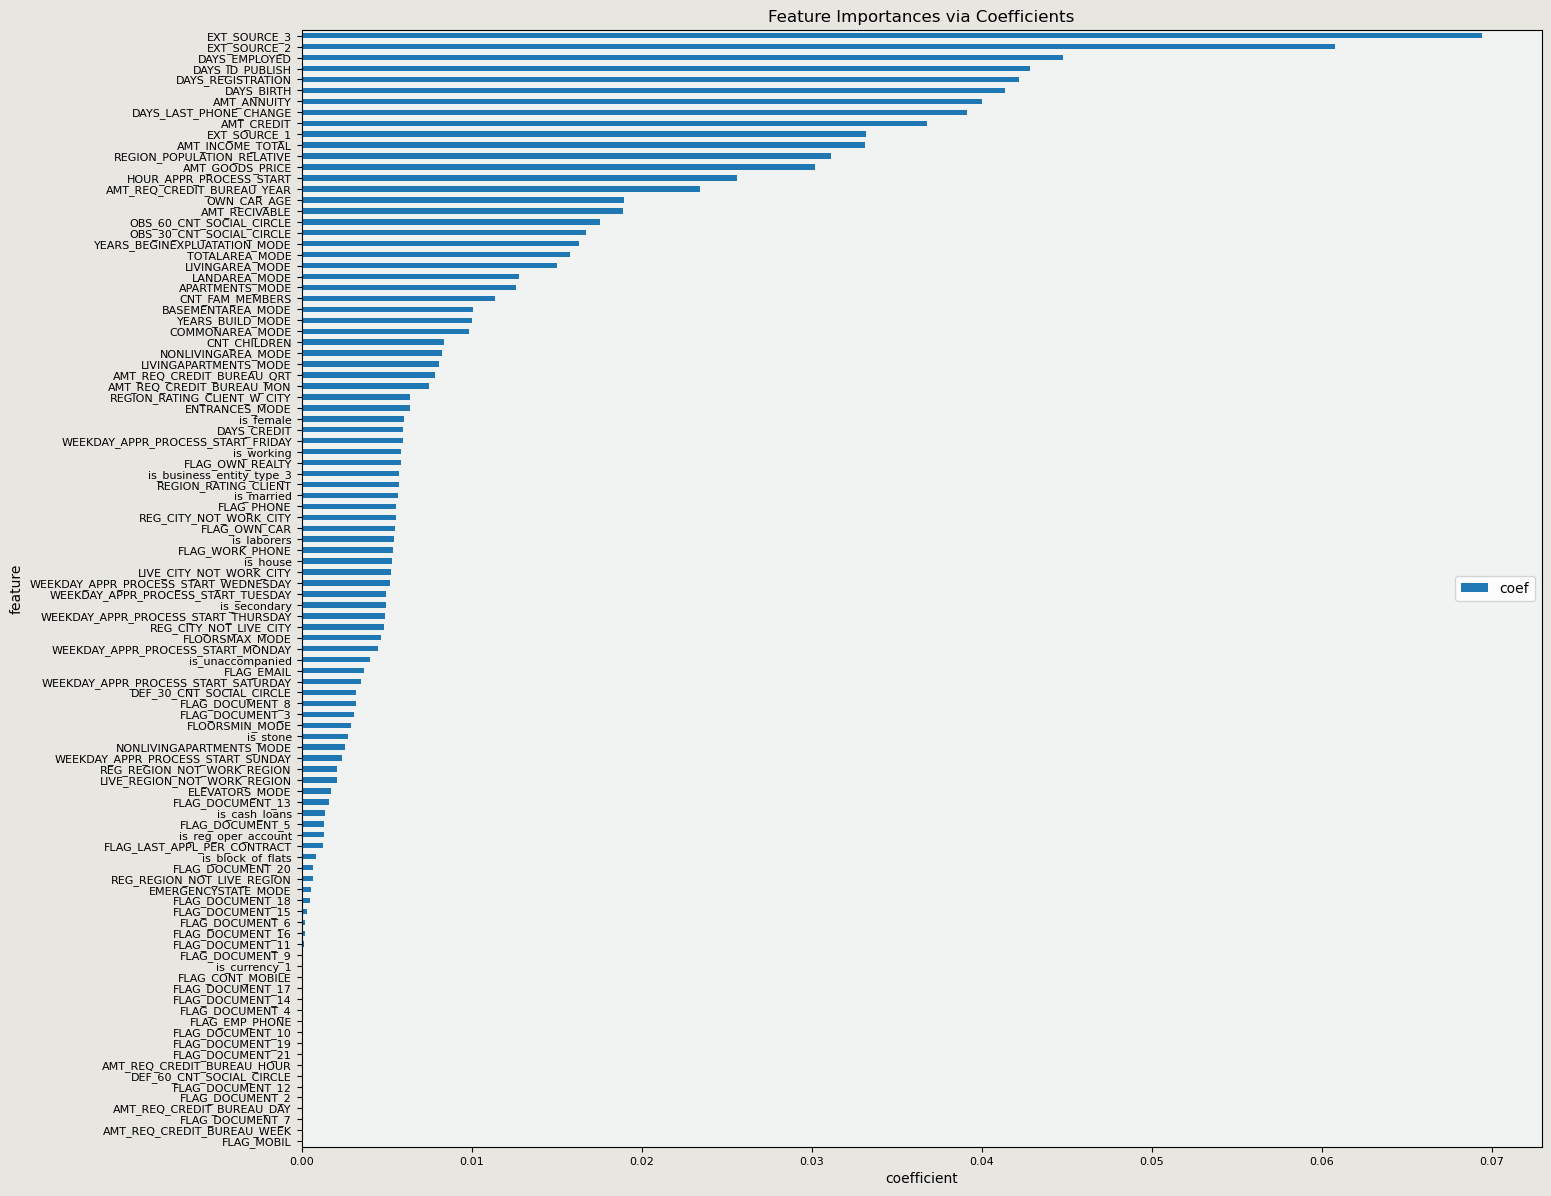

In [61]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
importance = np.abs(clf.feature_importances_)
feature_names = np.array(X_train.columns)
plt.figure(figsize = (16, 14.5), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
pd.DataFrame(list(zip(list(X_train.columns), clf.feature_importances_)), columns = ['feature', 'coef'])\
            .sort_values(by = ['coef'], ascending = True).reset_index(drop = True)\
            .plot(x = 'feature', kind = 'barh', fontsize = 8, ax = ax)
plt.title("Feature Importances via Coefficients")
plt.xlabel('coefficient')
plt.legend(loc = 'center right')

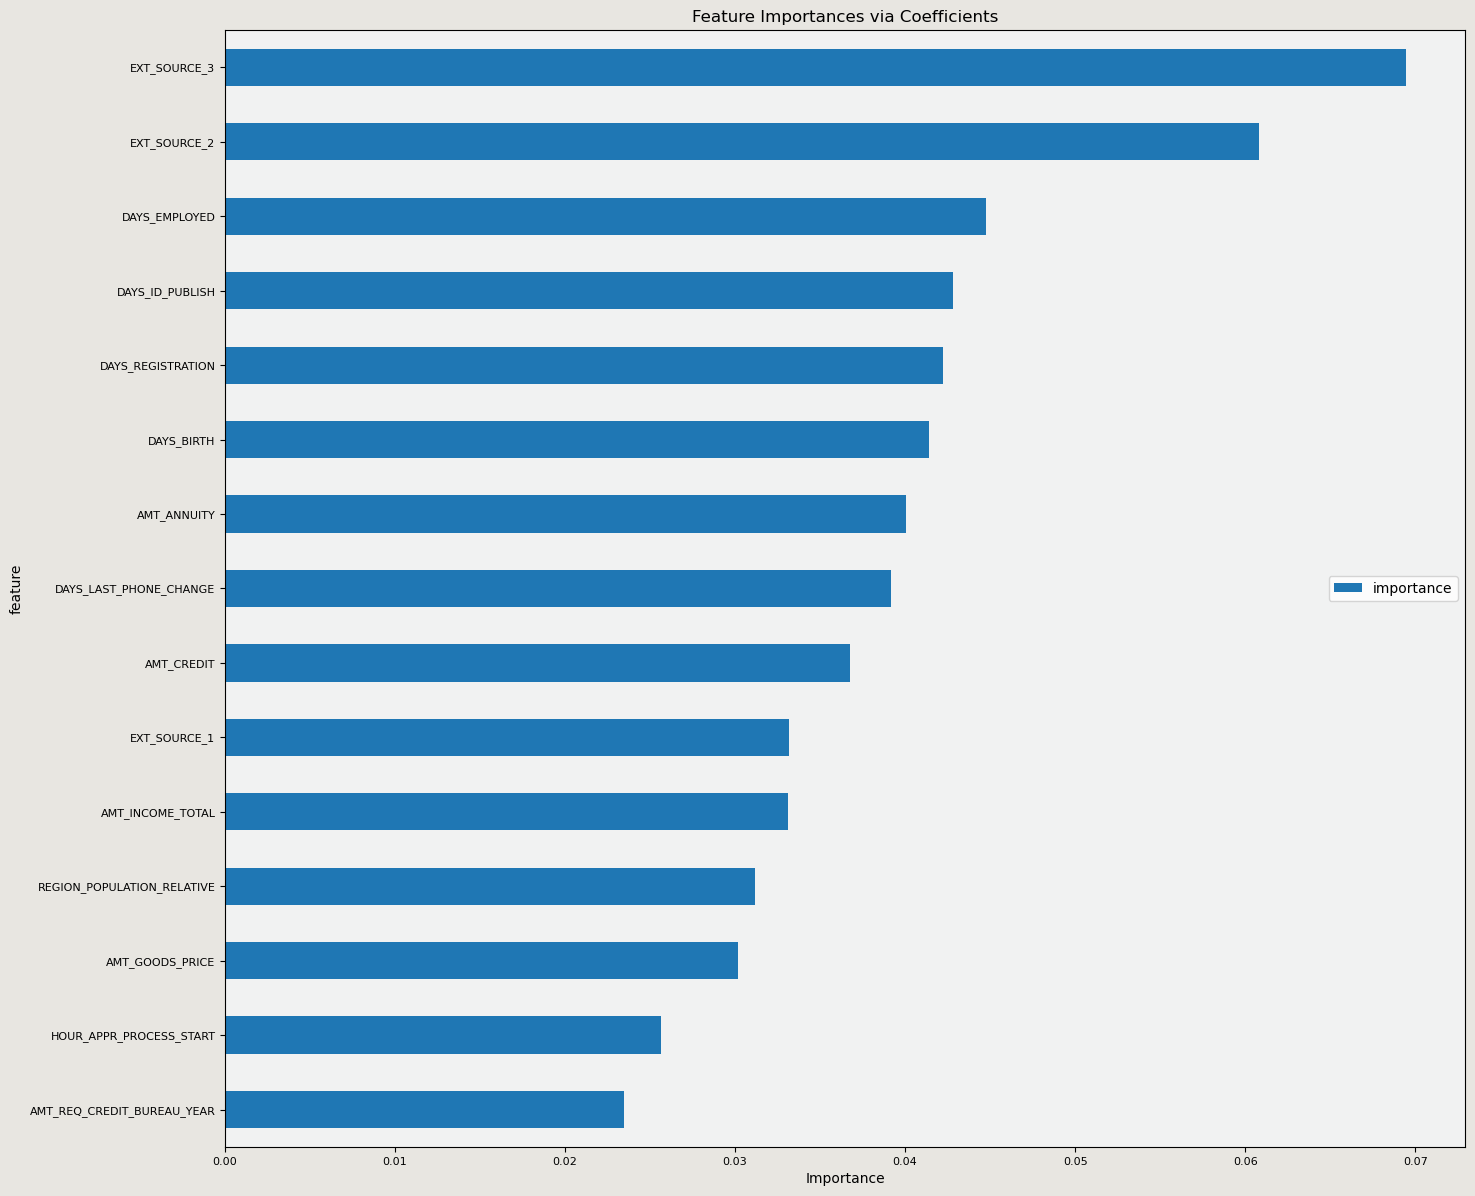

Selected Features:
3               AMT_INCOME_TOTAL
4                     AMT_CREDIT
5                    AMT_ANNUITY
6                AMT_GOODS_PRICE
7     REGION_POPULATION_RELATIVE
8                     DAYS_BIRTH
9                  DAYS_EMPLOYED
10             DAYS_REGISTRATION
11               DAYS_ID_PUBLISH
22       HOUR_APPR_PROCESS_START
29                  EXT_SOURCE_1
30                  EXT_SOURCE_2
31                  EXT_SOURCE_3
52        DAYS_LAST_PHONE_CHANGE
78    AMT_REQ_CREDIT_BUREAU_YEAR
Name: feature, dtype: object


In [62]:
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})

selected_features = feature_importance_df[feature_importance_df['importance'] >= 0.02]['feature']


plt.figure(figsize=(16, 14.5), facecolor='#e8e6e1')
ax = plt.axes()
ax.set_facecolor('#f1f2f2')
feature_importance_df.loc[feature_importance_df['feature'].isin(selected_features)]\
    .sort_values(by='importance', ascending=True)\
    .reset_index(drop=True)\
    .plot(x='feature', kind='barh', fontsize=8, ax=ax)
plt.title("Feature Importances via Coefficients")
plt.xlabel('Importance')
plt.legend(loc='center right')
plt.show()


print("Selected Features:")
print(selected_features)

In [63]:
col = ['AMT_INCOME_TOTAL',' AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE',
          'REGION_POPULATION_RELATIVE','DAYS_BIRTH', 'DAYS_EMPLOYED', ' DAYS_REGISTRATION',
          'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 
          'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', ' AMT_REQ_CREDIT_BUREAU_YEAR']

X_train = X_train.drop(columns = [i for i in X_train.columns if i not in col])

In [64]:
X_test = X_test.drop(columns = [i for i in X_test.columns if i not in col])

## Class Imbalance

Dikarenakan fitur target 'TARGET' itu memiliki data imbalance maka kami mempertimbangkan untuk handling class imbalance dengan SMOTE

In [65]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE(sampling_strategy = 0.5).fit_resample(X_train, y_train)

In [66]:
pd.concat([X_train, y_train], axis = 1).duplicated().sum()

147084

In [67]:
pd.concat([X_test, y_test], axis = 1).duplicated().sum()

56258

In [68]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = train.drop_duplicates()
test = test.drop_duplicates()

X_train = train.drop(columns=['TARGET'])
y_train = train[['TARGET']]

X_test = test.drop(columns=['TARGET'])
y_test = test[['TARGET']]